In [14]:
import json
import os
import pandas as pd
from bs4 import BeautifulSoup

# Define folder paths
json_folder = "/Users/avinishatiwari/Downloads/CAP_127/json"  # Update with actual path
html_folder = "/Users/avinishatiwari/Downloads/CAP_127/html"  # Update with actual path

# Initialize list to hold each case's data
cases_data = []

# Function to find the matching HTML file based on case ID or name
def find_matching_html(case_id, case_name):
    for html_filename in os.listdir(html_folder):
        if html_filename.endswith(".html"):
            html_path = os.path.join(html_folder, html_filename)
            with open(html_path, 'r') as f:
                soup = BeautifulSoup(f, 'html.parser')
                
                # Search for case ID or case name in HTML content
                if str(case_id) in soup.text or case_name in soup.text:
                    return html_filename
    return None

# Iterate through JSON files in the folder
for json_filename in os.listdir(json_folder):
    if json_filename.endswith(".json"):
        # Load each JSON file
        json_path = os.path.join(json_folder, json_filename)
        with open(json_path, 'r') as f:
            data = json.load(f)

        # Extract fields from JSON
        case_id = data.get('id')
        case_name = data.get('name')
        decision_date = data.get('decision_date')
        court_name = data.get('court', {}).get('name')
        jurisdiction = data.get('jurisdiction', {}).get('name_long')
        opinion_text = data['casebody']['opinions'][0]['text'] if 'casebody' in data and 'opinions' in data['casebody'] else ""

        # Find corresponding HTML file using the case ID or name
        html_filename = find_matching_html(case_id, case_name)
        
        if html_filename:
            html_path = os.path.join(html_folder, html_filename)
            with open(html_path, 'r') as f:
                soup = BeautifulSoup(f, 'html.parser')

            # Extract fields from HTML
            docket_number = soup.find("p", class_="docketnumber").text.strip() if soup.find("p", class_="docketnumber") else ""
            case_date = soup.find("p", class_="decisiondate").text.strip() if soup.find("p", class_="decisiondate") else ""
            parties = soup.find("h4", class_="parties").text.strip() if soup.find("h4", class_="parties") else ""

            # Extract main opinion text from HTML if available
            opinion_section = soup.find("article", class_="opinion")
            if opinion_section:
                opinion_body = ' '.join([p.text for p in opinion_section.find_all("p")])
            else:
                opinion_body = opinion_text  # Fallback to JSON opinion text if HTML parsing fails
        else:
            # If no matching HTML file is found, rely on JSON data only
            docket_number, case_date, parties = "", "", ""
            opinion_body = opinion_text

        # Append extracted data to the list
        cases_data.append({
            "Case ID": case_id,
            "Case Name": case_name,
            "Decision Date": decision_date,
            "Court Name": court_name,
            "Jurisdiction": jurisdiction,
            "Docket Number": docket_number,
            "Case Date": case_date,
            "Parties": parties,
            "Opinion Text": opinion_body
        })

# Convert the list of case data into a DataFrame
df = pd.DataFrame(cases_data)

# Display the consolidated DataFrame
print("Data extraction complete. Sample data:")
print(df.head())

Data extraction complete. Sample data:
   Case ID                                          Case Name Decision Date  \
0  6805909  TIMOTHY LEE HOBBS, Appellant, v. THE STATE OF ...    2011-05-19   
1  6806085  CLEAN WATER COALITION, a Nevada Joint Powers A...    2011-05-26   
2  6807346  KARL HOLT and FRANCES HOLT, Appellants, v. REG...    2011-12-15   
3  6807388  SICOR, INC., a Delaware Corporation; TEVA PARE...    2011-12-15   
4  6807617  FOURTH STREET PLACE, LLC, a Nevada Limited Lia...    2011-12-29   

                Court Name Jurisdiction Docket Number          Case Date  \
0  Supreme Court of Nevada       Nevada     No. 54933       May 19, 2011   
1  Supreme Court of Nevada       Nevada     No. 57649       May 26, 2011   
2  Supreme Court of Nevada       Nevada     No. 56479  December 15, 2011   
3  Supreme Court of Nevada       Nevada     No. 58887  December 15, 2011   
4  Supreme Court of Nevada       Nevada     No. 54415  December 29, 2011   

                             

In [15]:
import re
from textblob import TextBlob

# Text Cleaning Function
def clean_text(text):
    # Remove special characters, numbers, and convert to lowercase
    text = re.sub(r'[^A-Za-z\s]', '', text)
    text = text.lower().strip()
    return text

# Apply cleaning to the Opinion Text column
df['Cleaned Opinion Text'] = df['Opinion Text'].apply(clean_text)

# Sentiment Analysis Function
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Returns sentiment polarity (-1 to 1)

# Apply sentiment analysis
df['Sentiment Score'] = df['Cleaned Opinion Text'].apply(analyze_sentiment)

# Display the DataFrame with sentiment scores
print("Sentiment Analysis Complete. Sample Data:")
print(df[['Case ID', 'Case Name', 'Sentiment Score', 'Cleaned Opinion Text']].head())

Sentiment Analysis Complete. Sample Data:
   Case ID                                          Case Name  \
0  6805909  TIMOTHY LEE HOBBS, Appellant, v. THE STATE OF ...   
1  6806085  CLEAN WATER COALITION, a Nevada Joint Powers A...   
2  6807346  KARL HOLT and FRANCES HOLT, Appellants, v. REG...   
3  6807388  SICOR, INC., a Delaware Corporation; TEVA PARE...   
4  6807617  FOURTH STREET PLACE, LLC, a Nevada Limited Lia...   

   Sentiment Score                               Cleaned Opinion Text  
0        -0.057111  opinion by the court saitta j in this appeal w...  
1         0.072073  opinion by the court hardesty j confronting a ...  
2         0.014497  opinion by the court pickering j since  nevada...  
3         0.083056  opinion by the court hardesty j in this appeal...  
4        -0.023737  opinion by the court douglas j in this appeal ...  


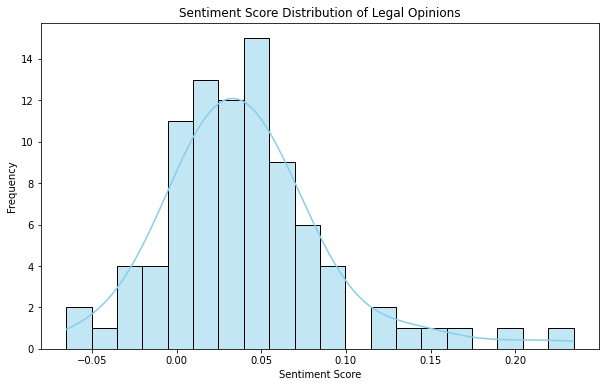

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Sentiment Distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['Sentiment Score'], bins=20, kde=True, color="skyblue")
plt.title("Sentiment Score Distribution of Legal Opinions")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.show()

In [4]:
print(type(df))

<class 'pandas.core.frame.DataFrame'>


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/avinishatiwari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/avinishatiwari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Identified Topics:
Topic 0: 0.025*"court" + 0.015*"district" + 0.011*"pd" + 0.010*"nev" + 0.007*"nrs"
Topic 1: 0.018*"court" + 0.011*"district" + 0.007*"pd" + 0.006*"nev" + 0.005*"motion"
Topic 2: 0.023*"court" + 0.013*"state" + 0.010*"district" + 0.009*"nrs" + 0.009*"pd"
Topic 3: 0.017*"court" + 0.017*"nrs" + 0.010*"district" + 0.010*"state" + 0.009*"nev"
Topic 4: 0.012*"state" + 0.012*"court" + 0.009*"nrs" + 0.008*"nev" + 0.008*"pd"


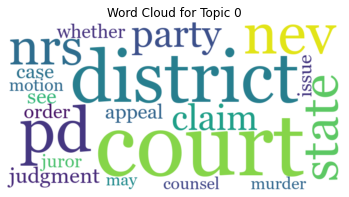

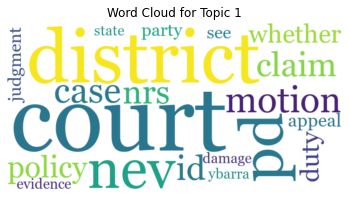

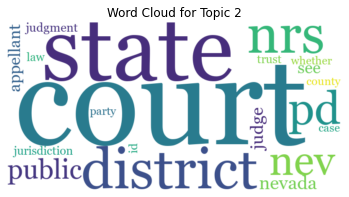

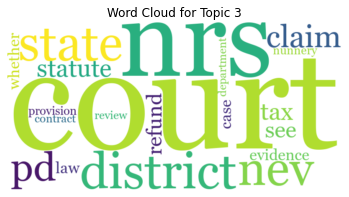

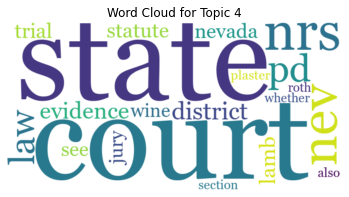

In [17]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Download stopwords if not already done
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Preprocessing function for LDA
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    tokens = gensim.utils.simple_preprocess(text, deacc=True)  # Tokenize and remove punctuation
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stop words and lemmatize
    return tokens

# Apply preprocessing to the opinion texts
df['Tokens'] = df['Cleaned Opinion Text'].apply(preprocess)

# Create dictionary and corpus
dictionary = corpora.Dictionary(df['Tokens'])
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]

# Build the LDA model
lda_model = LdaModel(corpus, num_topics=5, id2word=dictionary, passes=10, random_state=42)

# Display the topics
topics = lda_model.print_topics(num_words=5)
print("Identified Topics:")
for topic_num, topic in topics:
    print(f"Topic {topic_num}: {topic}")

# Visualize topics using word clouds
for i in range(lda_model.num_topics):
    plt.figure()
    plt.title(f"Word Cloud for Topic {i}")
    # Specify a TrueType font path (update the path to a valid TTF file on your system)
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/Users/avinishatiwari/Downloads/georgia/georgia.ttf').generate_from_frequencies(dict(lda_model.show_topic(i, topn=20)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [18]:
import gensim
from gensim import corpora
from gensim.models import LdaModel
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from ctm import CTM
import pandas as pd

# Download stopwords if not already done
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

# Additional domain-specific stopwords
domain_specific_stopwords = set(['court', 'district', 'state', 'pd', 'nrs', 'motion', 'example1', 'example2', 'example3'])  # Replace with actual domain-specific stopwords
stop_words = stop_words.union(domain_specific_stopwords)

# Preprocessing function for LDA
def preprocess(text):
    lemmatizer = WordNetLemmatizer()
    tokens = gensim.utils.simple_preprocess(text, deacc=True)  # Tokenize and remove punctuation
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]  # Remove stop words and lemmatize
    return tokens

# Assuming df is already defined and contains the 'Cleaned Opinion Text' column
df['Tokens'] = df['Cleaned Opinion Text'].apply(preprocess)

# Create dictionary and corpus
dictionary = corpora.Dictionary(df['Tokens'])
corpus = [dictionary.doc2bow(text) for text in df['Tokens']]

# Build the LDA model with increased number of topics and passes
lda_model = LdaModel(corpus, num_topics=10, id2word=dictionary, passes=20, random_state=42)

# Display the topics from LDA
print("Identified Topics from LDA:")
topics = lda_model.print_topics(num_words=5)
for topic_num, topic in topics:
    print(f"Topic {topic_num}: {topic}")

# Visualize topics using word clouds for LDA
for i in range(lda_model.num_topics):
    plt.figure()
    plt.title(f"Word Cloud for LDA Topic {i}")
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/Users/avinishatiwari/Downloads/georgia/georgia.ttf').generate_from_frequencies(dict(lda_model.show_topic(i, topn=20)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Build the CTM model
ctm_model = CTM(corpus=corpus, num_topics=10, id2word=dictionary)
ctm_model.fit()

# Display the topics from CTM
print("Identified Topics from CTM:")
ctm_topics = ctm_model.show_topics(num_words=5)
for topic_num, topic in ctm_topics:
    print(f"Topic {topic_num}: {topic}")

# Visualize topics using word clouds for CTM
for i in range(ctm_model.num_topics):
    plt.figure()
    plt.title(f"Word Cloud for CTM Topic {i}")
    wordcloud = WordCloud(width=800, height=400, background_color='white', font_path='/Users/avinishatiwari/Downloads/georgia/georgia.ttf').generate_from_frequencies(dict(ctm_model.show_topic(i, topn=20)))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

ImportError: cannot import name 'CTM' from 'ctm' (/Users/avinishatiwari/miniconda3/lib/python3.8/site-packages/ctm/__init__.py)

In [19]:
import ctm
print(ctm.__file__)

/Users/avinishatiwari/miniconda3/lib/python3.8/site-packages/ctm/__init__.py
